In [28]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Rohit@299',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/rohit/OneDrive/Documents/ecommerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [29]:
#import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mysql.connector

db = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Rohit@299',
    database='ecommerce')

cur = db.cursor()

# Basic Queries

### 1. List all unique cities where customers are located.

In [30]:
query = """select distinct customer_city from customers"""

cur.execute(query)
data =cur.fetchall()
data

df = pd.DataFrame(data, columns = ["Cities"])
df.head(5)

,Cities
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


### 2. Count the number of orders placed in 2017.

In [31]:
query = """select count(order_id) from orders where year(order_purchase_timestamp ) =2017 """

cur.execute(query)
data = cur.fetchall()
"Total orders placed in 201&",data[0][0]

('Total orders placed in 201&', 270606)

### 3. Find the total sales per category.

In [32]:
query = """select upper(products.product_category) cat, round(sum(payments.payment_value),2) sales
from products join
order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by cat"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Category","Sales"])
df

,Category,Sales
0,PERFUMERY,1.094556e+08
1,FURNITURE DECORATION,3.089181e+08
2,TELEPHONY,1.051665e+08
3,FASHION BAGS AND ACCESSORIES,4.712219e+07
4,BED TABLE BATH,3.699116e+08
...,...,...
69,CDS MUSIC DVDS,2.590769e+05
70,LA CUISINE,6.293225e+05
71,FASHION CHILDREN'S CLOTHING,1.697047e+05
72,PC GAMER,4.696769e+05


### 4. Calculate the percentage of orders that were paid in installments.

In [33]:
query = """select (sum(case when payment_installments >= 1 then 1
           else 0 end))/count(*)*100 from payments """

cur.execute(query)
data =cur.fetchall()
"The percentage of orders that were paid in installments is", data[0][0]

('The percentage of orders that were paid in installments is',
 Decimal('99.9981'))

### 5. Count the number of customers from each state.

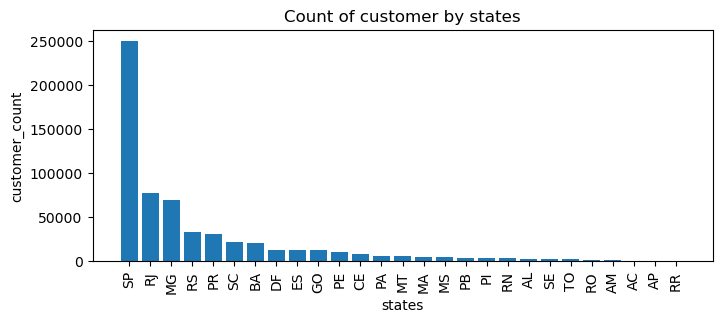

In [34]:
query = """select customer_state, count(customer_id)
           from customers group by customer_state"""

cur.execute(query)
data =cur.fetchall()
df = pd.DataFrame(data, columns = ["state","customer_count"])
df = df.sort_values(by = "customer_count", ascending = False)

plt.figure(figsize = (8,3))
plt.bar(df["state"], df["customer_count"])
plt.xticks(rotation = 90)
plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("Count of customer by states")
plt.show()

# Intermediate Queries

### 1. Calculate the number of orders per month in 2018.

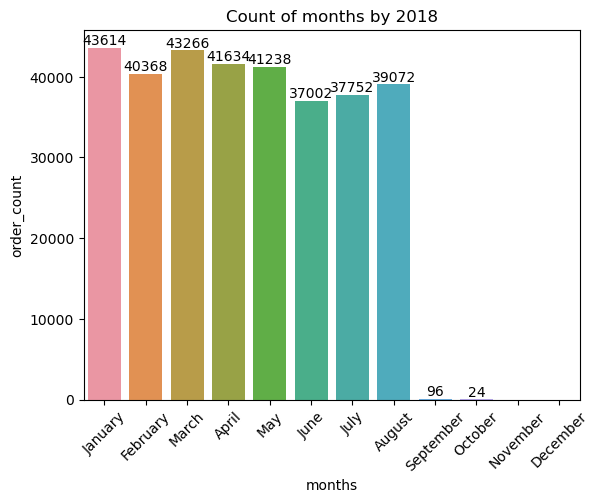

In [35]:
query = """select monthname(order_purchase_timestamp)months,count(order_id) order_count
           from orders 
           where year(order_purchase_timestamp)= 2018
           group by months
           """

cur.execute(query)
data =cur.fetchall()
data
df = pd.DataFrame(data, columns = ["months", "order_count"])
df
o = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
ax = sns.barplot(x = df["months"],y = df["order_count"],data = df ,order = o)
plt.xticks(rotation =45)
ax.bar_label(ax.containers[0])
plt.title("Count of months by 2018")
plt.show()

### 2. Find the average number of products per order, grouped by customer city.

In [36]:
query = """with count_per_order
as(select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders 
join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city
order by average_orders desc
"""

# Execute the query
cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns=["customer_city", "avg_products_per_order"])

# Display the DataFrame
df.head(5)

,customer_city,avg_products_per_order
0,padre carvalho,252.00
1,celso ramos,234.00
2,datas,216.00
3,candido godoi,216.00
4,matias olimpio,180.00


### 3. Calculate the percentage of total revenue contributed by each product category.

In [37]:
query ="""select upper(products.product_category) cat, 
round((sum(payments.payment_value)/(select sum(payments.payment_value)from payments))*100,2) sales_percentage
from products join
order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by cat order by sales_percentage desc"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["category", "Sales_percentage"])
df.head(5)

,category,Sales_percentage
0,BED TABLE BATH,385.11
1,HEALTH BEAUTY,372.70
2,COMPUTER ACCESSORIES,356.50
3,FURNITURE DECORATION,321.61
4,WATCHES PRESENT,321.40


### 4. Identify the correlation between product price and the number of times a product has been purchased.

In [38]:
import numpy as np
query = """select products.product_category,
count(order_items.product_id),
round(avg(order_items.price),2)
from products
join order_items
on products.product_id = order_items.product_id
group by products.product_category"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["category", "order_count","price"])

arr1 = df["order_count"] 
arr2 = df["price"]

a = np.corrcoef([arr1,arr2])
print("The correlation between price and an number of times product has been purchased",a[0][-1])

The correlation between price and an number of times product has been purchased -0.10631514167157556


### 5. Calculate the total revenue generated by each seller, and rank them by revenue.

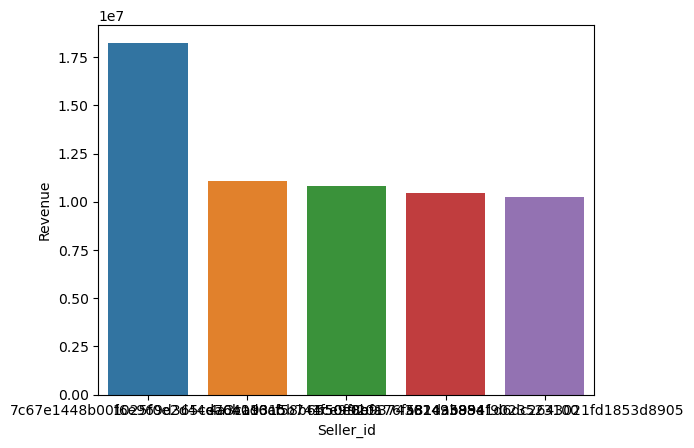

In [39]:
query = """ select *, dense_rank() over(order by revenue desc) as ro from 
(select order_items.seller_id,sum(payments.payment_value)
revenue from order_items join payments on 
            order_items.order_id = payments.order_id
            group by order_items.seller_id) as a """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Seller_id","Revenue","Rank"])
df = df.head()
sns.barplot(x= "Seller_id", y = "Revenue", data=df)
#plt.xticks(rotation = 45)
plt.show()

# Advanced Queries

### 1. Calculate the moving average of order values for each customer over their order history.

In [40]:
query = """
SELECT customer_id, order_purchase_timestamp, payment,
AVG(payment) OVER (PARTITION BY customer_id ORDER BY order_purchase_timestamp
ROWS BETWEEN 2 PRECEDING AND CURRENT ROW) AS mov_avg
FROM (
    SELECT orders.customer_id, orders.order_purchase_timestamp, payments.payment_value AS payment
    FROM payments
    JOIN orders ON payments.order_id = orders.order_id
) AS a
"""

cur.execute(query)
data = cur.fetchall()


df = pd.DataFrame(data, columns=['customer_id', 'order_purchase_timestamp', 'payment', 'mov_avg'])
df


,customer_id,order_purchase_timestamp,payment,mov_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
...,...,...,...,...
3739891,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
3739892,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
3739893,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
3739894,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


### 2. Calculate the cumulative sales per month for each year.

In [41]:
query =""" select years, months, payment, sum(payment)
over(order by years, months) cumulative_sales
from
(SELECT 
    YEAR(orders.order_purchase_timestamp) AS years,
    MONTH(orders.order_purchase_timestamp) AS months,
    round(sum(payments.payment_value),2) AS payment
FROM 
    orders 
JOIN 
    payments
ON 
    orders.order_id = payments.order_id
GROUP BY 
    years, months
ORDER BY 
    years, months) as Sales_data;
 """

cur.execute(query)
data = cur.fetchall()


df = pd.DataFrame(data, columns=['Years', 'Months', 'payment', 'Cumulative_sales'])
df

,Years,Months,payment,Cumulative_sales
0,2016,9,9080.64,9.080640e+03
1,2016,10,2127257.28,2.136338e+06
2,2016,12,706.32,2.137044e+06
3,2017,1,4985569.44,7.122614e+06
4,2017,2,10508688.34,1.763130e+07
5,2017,3,16195089.58,3.382639e+07
6,2017,4,15040369.06,4.886676e+07
7,2017,5,21345077.52,7.021184e+07
8,2017,6,18405949.69,8.861779e+07
9,2017,7,21325785.10,1.099436e+08


### 3. Calculate the year-over-year growth rate of total sales.

In [42]:
query = """
WITH a AS (
    SELECT 
        YEAR(orders.order_purchase_timestamp) AS years,
        ROUND(SUM(payments.payment_value), 2) AS payment
    FROM 
        orders 
    JOIN 
        payments
    ON 
        orders.order_id = payments.order_id
    GROUP BY 
        years
    ORDER BY 
        years
)
SELECT 
    years, 
    ((payment - LAG(payment, 1) OVER (ORDER BY years))/
    LAG(payment, 1) OVER (ORDER BY years)) + 100
    AS previous_year 
FROM a;
"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns=["years", "yoy % growth"])
df

,years,yoy % growth
0,2016,NaN
1,2017,221.127038
2,2018,100.200009


### 4. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [43]:
query = """ with a as(select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers 
join
    orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as(select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < date_add(first_order, interval 6 month)
group by a.customer_id)

select 100 * (count(distinct a. customer_id)/ count(distinct b.customer_id))
from a left join b 
on a.customer_id=b.customer_id;"""

cur.execute(query)
data = cur.fetchall()

data

[(None,)]

### 5. Identify the top 3 customers who spent the most money in each year.

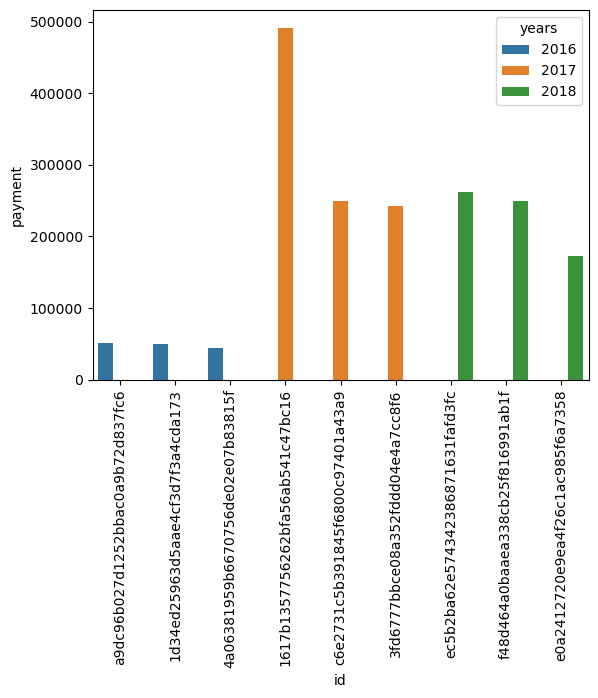

In [53]:
query =  """
            select years, customer_id, payment, d_rank 
from 

(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank()over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value)desc) d_rank
from orders 
join
payments
on payments.order_id = orders.order_id
group by (orders.order_purchase_timestamp),
orders.customer_id) as a 
where d_rank  <= 3;
"""

# Fetch data from the database
cur.execute(query)
data = cur.fetchall()

# Create a DataFrame
df = pd.DataFrame(data, columns=["years", "id", "payment", "D_Rank"])

# Convert 'id' (customer_id) and 'years' to strings to prevent any plotting issues
df["id"] = df["id"].astype(str)
df["years"] = df["years"].astype(str)

# Plot the bar plot
sns.barplot(x="id", y="payment", data=df, hue="years")
plt.xticks(rotation=90)
plt.show()


In [51]:
df["years"] = df["years"].astype('category')


In [52]:
print(df.dtypes)

years      category
id           object
payment     float64
D_Rank        int64
dtype: object
